## Project 10 - Marketing Strategy - Part 2

### Notebook Content

1. Dataset Sampling
2. Model Training and Evaluation with GridSearch 
3. Model Training and Evaluation with Bayesian Optimization


## 1. Dataset Sampling
---

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score 

from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [8]:
# G
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [22]:
# B
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

Import filtered dataset:

In [3]:
train = pd.read_csv('dataset/ds_train.csv')
test = pd.read_csv('dataset/ds_test.csv')

In [4]:
X_train = train.drop(columns='deposit')            
y_train = train['deposit']

X_test = test.drop(columns='deposit')            
y_test = test['deposit']

Checking size and formats:

In [5]:
print('X_train shape: {}, type: {}'.format(X_train.shape, type(X_train)))
print('y_train shape: {}, type: {}'.format(y_train.shape,type(y_train)))
print('X_test shape: {}, type: {}'.format(X_test.shape,type(X_test)))
print('y_test shape: {}, type: {}'.format(y_test.shape,type(y_test)))

X_train shape: (6239, 16), type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (6239,), type: <class 'pandas.core.series.Series'>
X_test shape: (2657, 16), type: <class 'pandas.core.frame.DataFrame'>
y_test shape: (2657,), type: <class 'pandas.core.series.Series'>


Confusion Matrix plotting function:

In [6]:
def plot_cm(y_pred_):                    
    cnf_matrix = confusion_matrix(y_test, y_pred_)
    plt.figure(figsize=(4,3))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.ylabel('Actual Label', size=7)
    plt.xlabel('Predicted Label', size=7)
    plt.show()    

Classification Report function:

In [80]:
def class_report(y_pred_):                                                        
    print(classification_report(y_test, y_pred_, target_names = ['not deposit','deposit']))

Cross-Validation Results Function:

In [18]:
# added with B
def cv_results(model):
    best_params = model.best_params_
    print("Best params:", best_params)
    best_score = model.best_score_
    print("Best score: {:.5f}".format(best_score))

## 2. Model Training and Evaluation with GridSearch
---

In [33]:
xgb = XGBClassifier(objective='binary:logistic',random_state=0) 

In [34]:
cv_params = {'max_depth': [3, 4, 6],
              'min_child_weight': [2, 3, 5],
              'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
              'n_estimators': [15,50,100,200],
              'subsample': [0.7, 0.9],
              'colsample_bytree': [0.7, 0.9]
              }

In [35]:
scoring = {'accuracy', 'precision', 'recall', 'f1'}

We will use a GridSearch with Stratified Kfold for the Cross Validation:

In [37]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=kfold, refit='f1')

In [39]:
xgb_cv.fit(X_train, y_train, verbose=True)
xgb_cv

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'max_depth': [3, 4, 6], 'min_child_weight': [2, 3, 5],
                         'n_estimators': [15, 50, 100, 200],
                         'subsample': [0.7, 0.9]},
             refit='f1', scoring={'f1', 'precision', 'recall', 'accuracy'})

Let's check the best params for the Cross-Validation:

In [ ]:
cv_results(xgb_cv)

Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.7}
Best score: 0.84162


In [21]:
pickle.dump(xgb_cv,open('xgb_cv.sav','wb'))

In [41]:
y_pred = xgb_cv.predict(X_test)

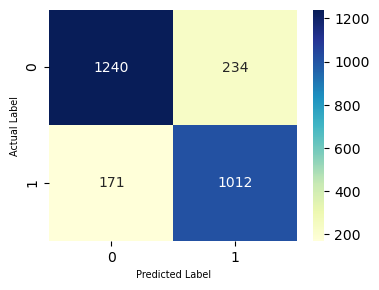

In [ ]:
plot_cm(y_pred)

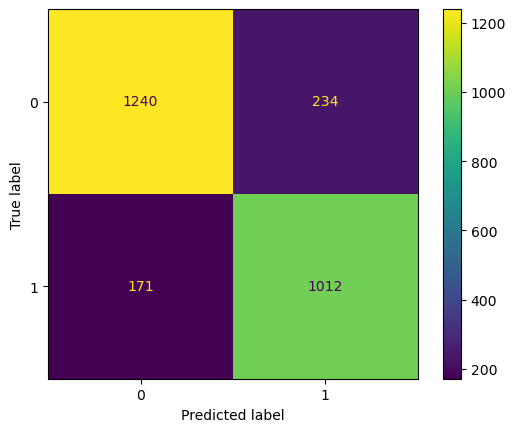

In [47]:
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)
disp.plot()
plt.show()

In [44]:
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.8475724501317276
precision score: 0.812199036918138
recall score: 0.8554522400676247
f1 score: 0.8332647179909428


In [43]:
class_report(y_pred)

              precision    recall  f1-score   support

    not risk       0.88      0.84      0.86      1474
        risk       0.81      0.86      0.83      1183

    accuracy                           0.85      2657
   macro avg       0.85      0.85      0.85      2657
weighted avg       0.85      0.85      0.85      2657



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

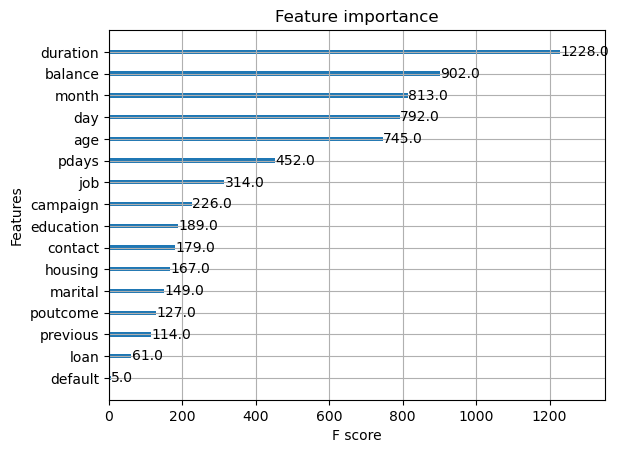

In [48]:
plot_importance(xgb_cv.best_estimator_)

## 3. Model Training and Evaluation with Bayesian Optimization
---

In [50]:
from skopt import BayesSearchCV
from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

Model definition:

In [51]:
xgb = XGBClassifier(objective='binary:logistic',random_state=0) 

Hyperparameter space:

In [53]:
param_grid = {
              'max_depth': (1, 8),
              'min_child_weight': (2, 3, 5),
              'learning_rate': (0.01, 0.99, 'log-uniform'),
              'n_estimators': (10, 200),     
              'subsample': (0.7, 0.9),
              'colsample_bytree': (0.7, 0.9),
              'min_samples_split': (0.001, 0.99, 'log-uniform'),
                          
              'loss': ['ls', 'lad', 'huber'],
              
             }

Bayesian Optimization:



In [54]:
model_xgb = BayesSearchCV(estimator=xgb,             
                          search_spaces=param_grid,
                          scoring='f1',
                          cv=5,
                          n_iter=50, 
                          random_state=42,
                          n_jobs=-1,
                          refit=True
                          )

In [56]:
model_xgb.fit(X_train, y_train)

[13:00:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "loss", "min_samples_split" } are not used.



BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      num_parallel_tree=None, predictor=None,
                                      random_state=0, ...),
              n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'colsample_bytree': (0.7, 0.9),
                             'learning_rate': (0.01, 0.99, 'log-uniform'),
                             'loss': ['ls', 'lad', 'huber'],
                             'max_depth': (1, 8), 'min_child_weight': (2, 3, 5),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (10, 200),
                             'subsample': (0.7, 0.9)})

In [58]:
model_xgb.best_params_

OrderedDict([('colsample_bytree', 0.9),
             ('learning_rate', 0.026065272003304153),
             ('loss', 'ls'),
             ('max_depth', 8),
             ('min_child_weight', 2),
             ('min_samples_split', 0.001),
             ('n_estimators', 171),
             ('subsample', 0.7971683995705787)])

In [61]:
results = pd.DataFrame(model_xgb.cv_results_)


Text(0.5, 0, 'Hyperparameter combinations')

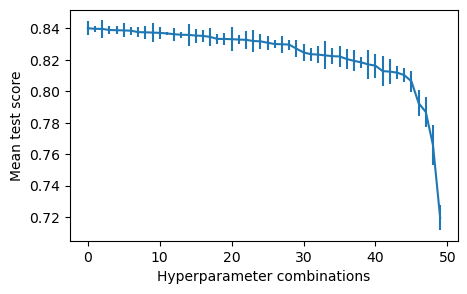

In [62]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

plt.figure(figsize=(5,3))
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [65]:
# X_train_preds = model_xgb.predict(X_train)
y_pred = model_xgb.predict(X_test)


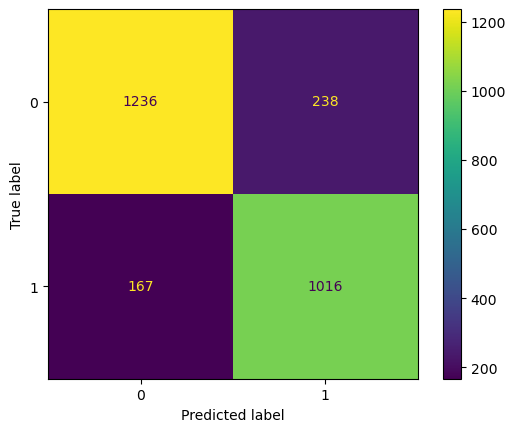

In [67]:
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot()
plt.show()

In [68]:
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.8475724501317276
precision score: 0.810207336523126
recall score: 0.8588334742180896
f1 score: 0.8338120640131309


In [81]:
class_report(y_pred)

              precision    recall  f1-score   support

 not deposit       0.88      0.84      0.86      1474
     deposit       0.81      0.86      0.83      1183

    accuracy                           0.85      2657
   macro avg       0.85      0.85      0.85      2657
weighted avg       0.85      0.85      0.85      2657



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

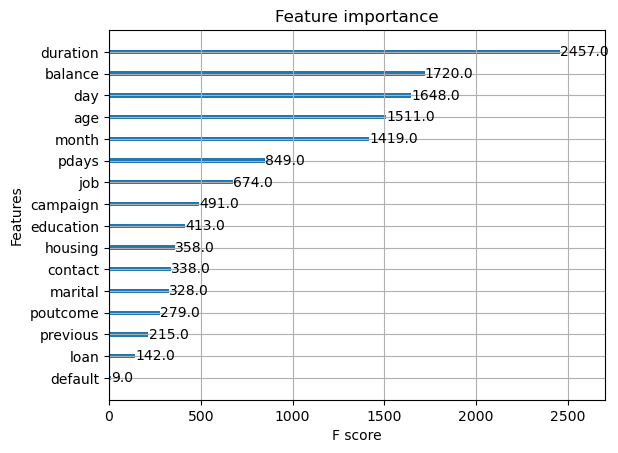

In [70]:
plot_importance(model_xgb.best_estimator_)

Search convergence evaluation:

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

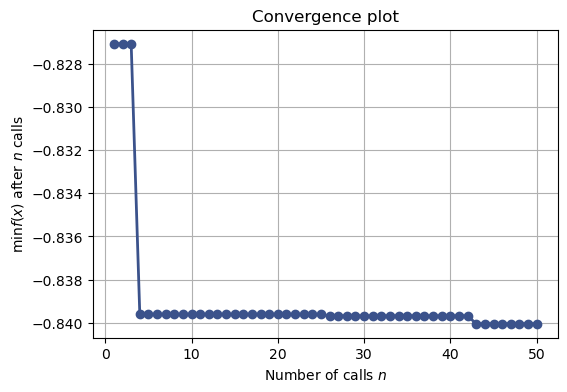

In [71]:
plt.figure(figsize = (6,4))
plot_convergence(model_xgb.optimizer_results_[0])

**Figure 2.** Models results for successive calls showing the bayesian search evolution.

We can see the model stabilizes after 42 rounds.

Partial dependence plots:

In [72]:
dims = ['n_estimators', 'min_samples_split', 'max_depth', 'loss', 'learning_rate']

In [78]:
# _ = plot_objective(model_xgb.optimizer_results_[0],
#                    dimensions=dims,
#                    n_minimum_search=int(1e8)
#                   )
# plt.show()                                   

**Figure 3.** Partial Dependence plots of the objective function. The red star is the best value for the given hyperparameter.

Evaluation order:

In [79]:
# _ = plot_evaluations(model_xgb.optimizer_results_[0],
#                      dimensions=dims,
#                      )
# plt.show()   

**Figure 4.** Color encoded order in which points were sampled during optimization. The red star is the best value for the given hyperparameter.